In [25]:
import pandas as pd 
import numpy as np
# from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool
# from profilestats import profile
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from os import listdir
import os
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Notebook to test differece between using flux and mags

In [17]:
# mag = np.random.normal(19,0.1,int(1e6))

In [18]:
flux = np.random.normal(1e-5,1e-6,int(1e7))

In [19]:
# flux = 10**(-(mag-8.9)/2.5)

In [20]:
mag = -2.5*np.log10(flux)+8.9

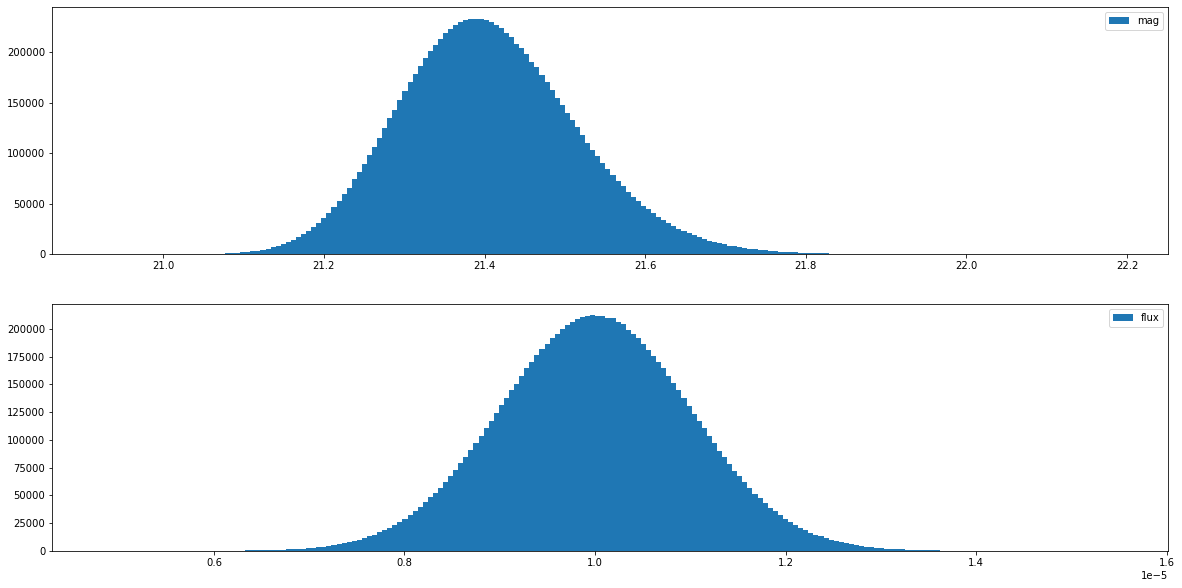

In [21]:
fig, axes = plt.subplots(2,1, figsize=(20,10))
axes[0].hist(mag, bins=200, label='mag');
axes[1].hist(flux, bins=200, label='flux');
for ax in axes:
    ax.legend()

## create synthetic data


In [22]:
def mock_lc_flux(n_obj, n_obs_lower, n_obs_upper, flux_mean=1e-4, flux_std_ensemble=6e-5, flux_std_object=1e-5):
    """
    Create a synthetic light curve of a random length between 100-200 observations assuming the fluxes are normally distributed then converting to mag

    Parameters
    ----------
    n_obj : int
        number of objects for which to create light curves
    flux_mean : float
        mean of gaussian 
    Returns
    -------
    df : DataFrame
        DataFrame containing synthetic light curves
    """
    fluxmeans = np.random.normal(flux_mean, flux_std_ensemble, size=n_obj) # Create a distribution of means which will be the mean flux of each object 
#     fluxerrs  = np.abs(np.random.normal(mag_err_object_mean, mag_err_object_std, size=n_obj)) # copied from mock_lc_mags. Need to adjust for 
    N   = np.random.randint(n_obs_lower,n_obs_upper, size=n_obj) # Create a random int between 100-200 which will be the number of observations for each object
    mag_fn = lambda flux: -2.5*np.log10(flux)+8.9 # Function to convert from flux to mag
    
    def fn(n, fluxmean):
        mjd = np.sort(np.random.uniform(5000,6000, size=n)) # Create a random set of mjds for one object
        mag = mag_fn(np.random.normal(fluxmean, flux_std_object, size=n)) # Create a normal distribution of fluxes with given width for one object, then convert to mags
        cat = np.sort(np.random.randint(1,4, size=n)) # Randomly assign observations to a given survey
        return mjd, mag, cat
    
    df = pd.DataFrame(columns=['uid','mjd','mag','cat'])
    for i in range(n_obj):
        mjd, mag, cat = fn(N[i], fluxmeans[i])
        uid = np.full(N[i], i, dtype='uint32')
        df = df.append(pd.DataFrame({'uid':uid,'mjd':mjd, 'mag':mag, 'cat':cat}))
    
    df = df.set_index('uid')
    return df

In [20]:
class sim():
    def __init__(self, n_obj, n_obs_lower, n_obs_upper, mag_mean=18.9, mag_std_ensemble=2, mag_err_object_mean=0.094, mag_err_obj_std=0.001):
        self.n_obj = n_obj
        self.n_obs_lower = n_obs_lower
        self.n_obs_upper = n_obs_upper
        self.mag_mean = mag_mean
        self.mag_std_ensemble = mag_std_ensemble
        self.mag_err_object_mean = mag_err_object_mean
        self.mag_err_object_std = mag_err_obj_std

    def create_lc_multiproc(self, n_obj_idx):
        
        def fn(n, magmean, magerr):
            mjd = np.sort(np.random.uniform(5000,6000, size=n))
            mag = np.random.normal(magmean, magerr, size=n)
            cat = np.random.randint(1,4, size=n)
            return mjd, mag, cat
        
        df = pd.DataFrame(columns=['uid','mjd','mag','cat'])
        for i in n_obj_idx:
            mjd, mag, cat = fn(self.N[i], self.magmeans[i], self.magerrs[i])
            uid = np.full(self.N[i], i, dtype='uint32')
            df = df.append(pd.DataFrame({'uid':uid,'mjd':mjd, 'mag':mag, 'cat':cat}))
        return df
    
    def mock_lc_mags(self, p, p_edges):
        """
        Create a synthetic light curve of a random length between n_obs_lower - n_obs_upper observations assuming the mags are normally distributed
        # Note, this assumes intrinsic variability is zero. Needs to be changed if we wish to use it for quasars
        Parameters
        ----------
        n_obj : int
            number of objects for which to create synthetic light curves

        Returns
        -------
        df : DataFrame
            DataFrame containing synthetic light curve
        """
        self.magmeans = np.random.normal(self.mag_mean, self.mag_std_ensemble, size=self.n_obj)
#         self.magerrs = np.abs(np.random.normal(self.mag_err_object_mean, self.mag_err_object_std, size=self.n_obj)) # take absolute value to avoid negative magerr
        p_centres = (p_edges[1:] + p_edges[:-1])/2
        self.magerrs = np.random.choice(p_centres, p=p*(p_edges[1] - p_edges[0]), size=self.n_obj)
        self.N   = np.random.randint(self.n_obs_lower, self.n_obs_upper, size=self.n_obj)

        df = pd.DataFrame(columns=['uid','mjd','mag','cat'])
        
        n_cores = 4
        pool = Pool(n_cores)
        df_list = pool.map(self.create_lc_multiproc, np.array_split(np.arange(self.n_obj),n_cores))
        df = pd.concat(df_list)
        
        self.lc = df.set_index('uid')
    
    def calculate_dtdm_multiproc(self, uids):
        """
        Create dtdm pairs for a given light curve

        Parameters
        ----------
        lc : DataFrame
            DataFrame of the light curve data

        Returns
        -------
        df : DataFrame
            DataFrame of the dtdm data for the given light curve
        """
        subgroup = self.lc.loc[uids]
        df = pd.DataFrame()
        for uid, subgroup in subgroup.groupby('uid'):
            #maybe groupby then iterrows? faster?
            mjd_mag = subgroup[['mjd','mag']].values
            cat	 = subgroup['cat'].values
            n = len(mjd_mag)
            # dtdm defined as: ∆m = (m2 - m1), ∆t = (t2 - t1) where (t1, m1) is the first obs and (t2, m2) is the second obs.
            # Thus a negative ∆m corresponds to a brightening of the object
            dcat = 3*cat + cat[:,np.newaxis]
            dcat = dcat[np.triu_indices(n,1)]

            dtdm = mjd_mag - mjd_mag[:,np.newaxis,:]
            dtdm = dtdm[np.triu_indices(n,1)]
            dtdm = dtdm*np.sign(dtdm[:,0])[:,np.newaxis]

            duid = np.full(int(n*(n-1)/2), uid,dtype='uint32')
            # collate data to DataFrame and append
            df = df.append(pd.DataFrame(data={'uid':duid,'dt':dtdm[:,0],'dm':dtdm[:,1],'cat':dcat}))
        
        return df.set_index('uid')
    
    def calculate_dtdm(self):
        n_cores = 4
        pool = Pool(n_cores)
        df_list = pool.map(self.calculate_dtdm_multiproc, np.array_split(self.lc.index.unique(),n_cores))
        self.dtdm = pd.concat(df_list)
        
    def plot_dm(self, window_width):
        # Fit a Gaussian
        def gaussian(x,peak):
            x0=0
            sigma = (2*np.pi)**-0.5*1/peak
            return peak*np.exp( -( (x-x0)**2/(2*sigma**2) ) )

        def exponential(x,peak,exponent):
            return peak*np.exp(-np.abs(x)*exponent)

        x = np.linspace(-window_width,window_width,1000)

        fig, ax = plt.subplots(1,1, figsize=(20,10))

        # Flux
        # m, bin_edges, _ = ax.hist(dtdm_flux['dm'], bins=400, color='b', density=True, alpha=0.5, range=(-window_width, window_width), label='flux')
        # bin_centres = (bin_edges[1:] + bin_edges[:-1])/2
        # popt, _ = curve_fit(gaussian, bin_centres, m, p0 = [m.max()])
        # ax.plot(x,gaussian(x, m.max()), color='b', label = 'gaussian fit to flux')

        # Mag
        m, bin_edges, _ = ax.hist(self.dtdm['dm'], bins=400, color='r', density=True, alpha=0.5, range=(-window_width, window_width), label='dtdm mag')
        bin_centres = (bin_edges[1:] + bin_edges[:-1])/2

        popt, _ = curve_fit(gaussian, bin_centres, m, p0 = [m.max()])
        ax.plot(x,gaussian(x, *popt), color='r', label = 'gaussian')

        popt, _ = curve_fit(exponential, bin_centres, m, p0 = [m.max(), 1])
        ax.plot(x,exponential(x, *popt), color='b', label = 'exponential')

        # ax.set(yscale='log')
        ax.set(xlim=[-window_width, window_width])
#         ax.legend()
        ax.axvline(x=0, color='k', ls='--', lw=1)
        
        return fig, ax


In [37]:
import sys
sys.path.append('../')
from funcs.analysis.analysis import analysis
# obj = 'qsos'
# ID  = 'uid'
redshift_bool = False
obj = 'calibStars'
ID = 'uid_s'
band = 'r'
# redshift_bool = True

dr = analysis(ID, obj)
dr.band = band

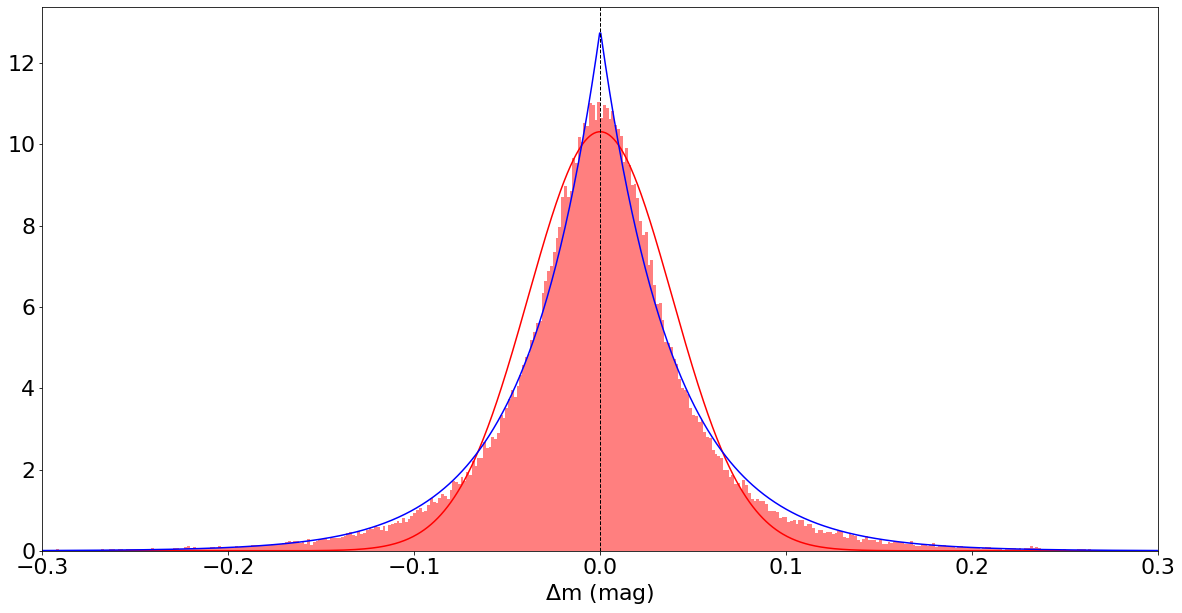

In [40]:
from matplotlib import rc
rc('font', **{'size':22})

dr.group(keys = [ID],read_in=True, redshift=redshift_bool, survey = 'sdss')
p, p_edges = np.histogram(dr.df_grouped['magerr_med'], bins=150, range=(0,0.3), density=True)

n_obj = int(2e3)
n_obs_lower = 2
n_obs_upper = 2e1

mag_peak = 20.4
# mag_peak = 21

mag_std_ensemble = 1.03
mag_err_object_mean = 0.05
mag_err_object_std  = 0.03

s = sim(n_obj, n_obs_lower, n_obs_upper, mag_peak, mag_std_ensemble, mag_err_object_mean, mag_err_object_std)
s.mock_lc_mags(p, p_edges)
s.calculate_dtdm()
fig, ax = s.plot_dm(0.3)
ax.set(xlabel=r'$\Delta$m (mag)')
fig.savefig('/disk1/hrb/python/analysis/plots/dm_simulated_sdss.pdf', bbox_inches='tight')

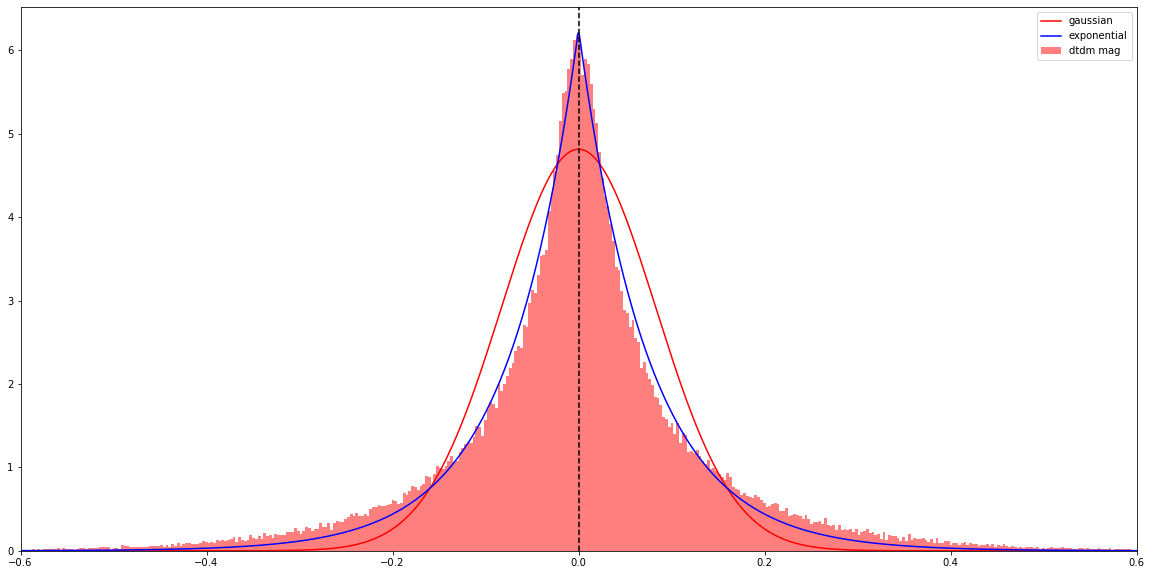

In [10]:
dr.group(keys = ['uid'],read_in=True, redshift=redshift_bool, survey = 'ps')
p, p_edges = np.histogram(dr.df_grouped['magerr_med'], bins=150, range=(0,0.3), density=True)

n_obj = int(2e3)
n_obs_lower = 2
n_obs_upper = 2e1

mag_peak = 20.4
# mag_peak = 21
mag_std_ensemble = 1.03

mag_err_object_mean = 0.05
mag_err_object_std  = 0.03


s = sim(n_obj, n_obs_lower, n_obs_upper, mag_peak, mag_std_ensemble, mag_err_object_mean, mag_err_object_std)
s.mock_lc_mags(p, p_edges)
s.calculate_dtdm()
s.plot_dm(0.6)

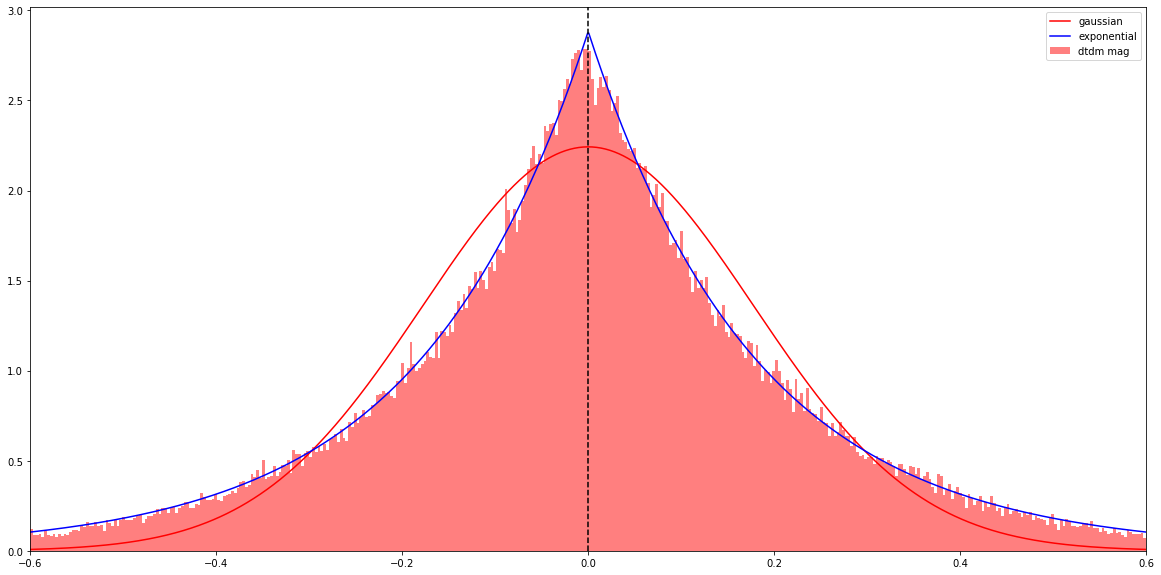

In [11]:
dr.group(keys = ['uid'],read_in=True, redshift=redshift_bool, survey = 'ztf')
p, p_edges = np.histogram(dr.df_grouped['magerr_med'], bins=150, range=(0,0.3), density=True)

n_obj = int(2e3)
n_obs_lower = 2
n_obs_upper = 2e1

mag_peak = 20.4
# mag_peak = 21
mag_std_ensemble = 1.03

mag_err_object_mean = 0.05
mag_err_object_std  = 0.03


s = sim(n_obj, n_obs_lower, n_obs_upper, mag_peak, mag_std_ensemble, mag_err_object_mean, mag_err_object_std)
s.mock_lc_mags(p, p_edges)
s.calculate_dtdm()
s.plot_dm(0.6)

In [ ]:
# group1['mag'] += (group1['cat']==1)*2 # This introduces a constant step (in photometry) between surveys